# Model Evaluation

## Imports and Setup

In [27]:
import sys
sys.path.append("..")

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [6]:
# Paths
MODELS = "../models/"
DATA_PATH = "../data/validation.txt"

# Load label encoders (reuse from training)
from utils.preprocess import load_data, get_label_encoder

# Load training data just for label2id mapping
train_df = load_data("../data/train.txt")
label2id, id2label = get_label_encoder(train_df["label"])


## Load and Preprocess Validation Dataset

In [8]:
val_df = load_data(DATA_PATH)
val_df["label_id"] = val_df["label"].map(label2id)

print("Sample validation data:")
print(val_df.head())


Sample validation data:
                                                text    label  label_id
0  im feeling quite sad and sorry for myself but ...  sadness         4
1  i feel like i am still looking at a blank canv...  sadness         4
2                     i feel like a faithful servant     love         3
3                  i am just feeling cranky and blue    anger         0
4  i can have for a treat or if i am feeling festive      joy         2


## FCNN Evaluation

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

fcnn_model = load_model(os.path.join(MODELS, "fcnn_model.keras"))

tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(train_df['text'])

X_val_fcnn = tfidf.transform(val_df["text"]).toarray()
y_true = val_df["label_id"].values

# Predict
y_pred_probs = fcnn_model.predict(X_val_fcnn)
y_pred_fcnn = np.argmax(y_pred_probs, axis=1)

print("\nFCNN on Validation Set:\n")
print(classification_report(y_true, y_pred_fcnn, target_names=label2id.keys(), zero_division=0))
report_fcnn = classification_report(
    y_true, y_pred_fcnn,
    target_names=label2id.keys(),
    output_dict=True,
    zero_division=0
)

63/63 [==============================] - 0s 2ms/step

FCNN on Validation Set:

              precision    recall  f1-score   support

       anger       0.89      0.85      0.87       275
        fear       0.80      0.82      0.81       212
         joy       0.91      0.91      0.91       704
        love       0.80      0.76      0.78       178
     sadness       0.88      0.93      0.90       550
    surprise       0.82      0.74      0.78        81

    accuracy                           0.88      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.88      0.88      0.87      2000



## RNN with LSTM Evaluation

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load model
rnn_model = load_model(os.path.join(MODELS, "rnn_model.keras"))

# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"])

X_val_seq = tokenizer.texts_to_sequences(val_df["text"])
X_val_pad = pad_sequences(X_val_seq, maxlen=50, padding='post', truncating='post')

y_pred_probs_rnn = rnn_model.predict(X_val_pad)
y_pred_rnn = np.argmax(y_pred_probs_rnn, axis=1)

print("\nRNN on Validation Set:\n")
print(classification_report(y_true, y_pred_rnn, target_names=label2id.keys(), zero_division=0))

report_rnn = classification_report(
    y_true, y_pred_rnn,
    target_names=label2id.keys(),
    output_dict=True,
    zero_division=0
)

63/63 [==============================] - 1s 7ms/step

RNN on Validation Set:

              precision    recall  f1-score   support

       anger       0.94      0.92      0.93       275
        fear       0.91      0.78      0.84       212
         joy       0.93      0.92      0.93       704
        love       0.82      0.82      0.82       178
     sadness       0.91      0.96      0.93       550
    surprise       0.75      0.86      0.80        81

    accuracy                           0.91      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.91      0.91      0.91      2000



## Transformer (Bert based) Evaluation

In [24]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer
from torch.utils.data import Dataset
import torch

# Load tokenizer and model
bert_path = os.path.join(MODELS, "bert_model")
tokenizer = BertTokenizer.from_pretrained(bert_path)
model = BertForSequenceClassification.from_pretrained(bert_path)
model.eval()

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

val_dataset = EmotionDataset(val_df["text"].tolist(), val_df["label_id"].tolist(), tokenizer)

trainer = Trainer(model=model)
preds_output = trainer.predict(val_dataset)
y_pred_bert = np.argmax(preds_output.predictions, axis=1)

print("\nBERT on Validation Set:\n")
print(classification_report(y_true, y_pred_bert, target_names=label2id.keys(), zero_division=0))
report_bert = classification_report(
    y_true, y_pred_bert,
    target_names=label2id.keys(),
    output_dict=True,
    zero_division=0
)



BERT on Validation Set:

              precision    recall  f1-score   support

       anger       0.94      0.93      0.93       275
        fear       0.88      0.94      0.91       212
         joy       0.96      0.96      0.96       704
        love       0.92      0.87      0.89       178
     sadness       0.96      0.97      0.96       550
    surprise       0.92      0.81      0.86        81

    accuracy                           0.94      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.94      0.94      0.94      2000



# Model Comparision

In [25]:
summary_df = pd.DataFrame({
    "Model": ["FCNN", "RNN", "BERT"],
    "Accuracy": [
        report_fcnn["accuracy"],
        report_rnn["accuracy"],
        report_bert["accuracy"]
    ],
    "Precision (macro avg)": [
        report_fcnn["macro avg"]["precision"],
        report_rnn["macro avg"]["precision"],
        report_bert["macro avg"]["precision"]
    ],
    "Recall (macro avg)": [
        report_fcnn["macro avg"]["recall"],
        report_rnn["macro avg"]["recall"],
        report_bert["macro avg"]["recall"]
    ],
    "F1-score (macro avg)": [
        report_fcnn["macro avg"]["f1-score"],
        report_rnn["macro avg"]["f1-score"],
        report_bert["macro avg"]["f1-score"]
    ]
})

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

display(summary_df.round(4))


,Model,Accuracy,Precision (macro avg),Recall (macro avg),F1-score (macro avg)
0,FCNN,0.8755,0.8523,0.8339,0.8424
1,RNN,0.9055,0.8775,0.8774,0.8758
2,BERT,0.9435,0.9292,0.9150,0.9213


## Which Model Best Understands Emotions?

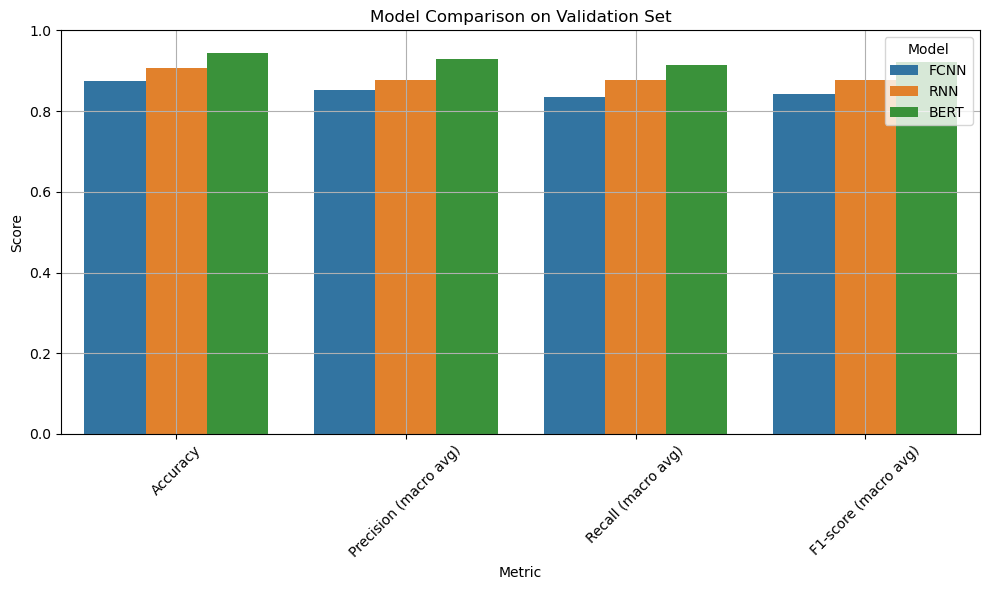

In [26]:
melted = summary_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x="Metric", y="Score", hue="Model")
plt.title("Model Comparison on Validation Set")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()



We tested three different models - BERT, RNN, and FCNN, to see how well they could recognize emotions. We looked at four key things: Accuracy, Precision, Recall, F1-score.

What We Found
Here, as we see the scores, BERT is the best model. It significantly outperformed both RNN and FCNN.

- Its high F1-score (0.9213) tells us that BERT is excellent at recognizing emotions, consistently and accurately for all types of feelings.

- RNN did a pretty good job, noticeably better than FCNN, especially when it came to finding all the examples of each emotion (recall) and its overall balanced performance (F1-score).

- FCNN, while simpler and faster, struggled a bit. It didn't do as well at picking up on the subtle differences between emotions, resulting in a bit lower F1-score (0.8424). 


If we need a model that's truly excellent at understanding and classifying emotions, BERT is your best one here. It's highly accurate and performs consistently well across all emotion categories. RNN is a solid alternative, while FCNN is more of a basic option that can identify general emotions but misses the finer details.

## How Confident Are Our Emotion Models?

63/63 [==============================] - 1s 23ms/step


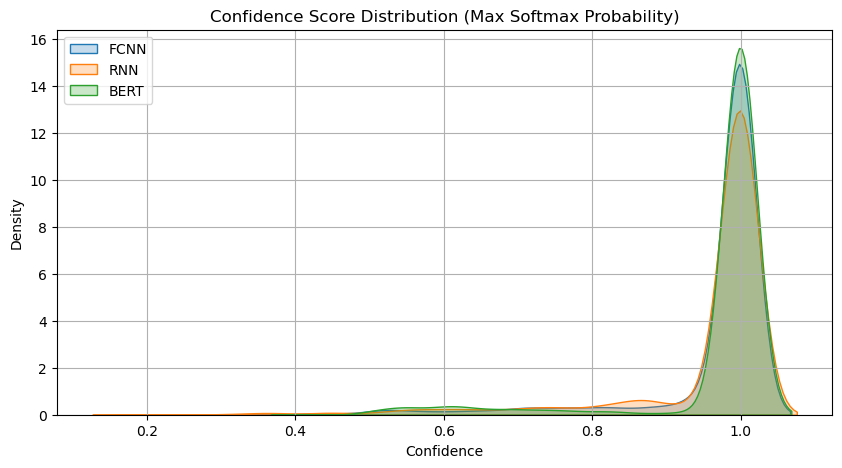

In [37]:
from scipy.special import softmax

# FCNN confidence scores
conf_fcnn = np.max(fcnn_model.predict(X_val_fcnn), axis=1)

# RNN confidence scores
conf_rnn = np.max(rnn_model.predict(X_val_pad), axis=1)

# BERT confidence scores (convert logits to softmax probs)
logits_bert = preds_output.predictions  # from trainer.predict()
probs_bert = softmax(logits_bert, axis=1)
conf_bert = np.max(probs_bert, axis=1)

plt.figure(figsize=(10, 5))
sns.kdeplot(conf_fcnn, label="FCNN", fill=True)
sns.kdeplot(conf_rnn, label="RNN", fill=True)
sns.kdeplot(conf_bert, label="BERT", fill=True)
plt.title("Confidence Score Distribution (Max Softmax Probability)")
plt.xlabel("Confidence")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

This graph tells us how "sure" our FCNN and RNN models are when they make a prediction about an emotion.

`x-axis` : This goes from low confidence (closer to 0) to very high confidence (closer to 1.0).

`y-axis` : This shows how many of the predictions fall into each confidence level. A taller bar means more predictions had that level of confidence.


- BERT shows the highest peak near 1.0, suggesting it is the most consistently confident in its predictions.

- RNN has a slightly broader distribution than BERT, meaning it makes more moderate-confidence predictions in some cases.

- FCNN, though also confident, has a slightly less sharp peak compared to BERT and RNN.


All models are highly confident, but:

- BERT is both highly confident and more accurate (as per earlier metrics) — a strong sign of calibration.

- RNN makes a few more uncertain predictions (a small bump around 0.6–0.8).

- FCNN shows slightly lower overall confidence density than BERT, aligning with its slightly weaker performance.

BERT not only outperforms in accuracy and F1, but also demonstrates the most confident and well-calibrated prediction behavior. RNN follows closely, while FCNN shows reasonable confidence but slightly less consistency.

## Mislabelled prediction samples

In [38]:
val_df["true"] = y_true
val_df["pred_fcnn"] = y_pred_fcnn
val_df["pred_rnn"] = y_pred_rnn
val_df["pred_bert"] = y_pred_bert

def show_misclassifications(df, model_col, num=5):
    mismatches = df[df[model_col] != df["true"]]
    print(f"\nShowing {num} misclassified examples from {model_col}:\n")
    for _, row in mismatches.sample(num, random_state=42).iterrows():
        print(f"Text: {row['text']}")
        print(f"True: {id2label[row['true']]}, Predicted: {id2label[row[model_col]]}")
        print("---")

show_misclassifications(val_df, "pred_fcnn")
show_misclassifications(val_df, "pred_rnn")
show_misclassifications(val_df, "pred_bert")



Showing 5 misclassified examples from pred_fcnn:

Text: i feel so alone in the world with nobody to talk to to share my feelings with
True: sadness, Predicted: fear
---
Text: i can really decode but im sorry i have to vomit my feelings out because i am so cranky and everything is getting on my nerves
True: anger, Predicted: sadness
---
Text: i consistently anticipation it s like that because i feel so admired and i feel so like safe in nature
True: love, Predicted: joy
---
Text: ive never been particularly bothered about my age or the ageing process and while i feel slightly surprised that im nearly i dont really mind
True: surprise, Predicted: anger
---
Text: i said it when i read about people who are loosing more weight losing it quicker or who are just being generally more fabulous than me i feel envious
True: anger, Predicted: joy
---

Showing 5 misclassified examples from pred_rnn:

Text: i so desperately want to be able to help but i feel so helpless
True: fear, Predicted: sadne

This evaluation step shows a few examples from the validation dataset where each model made an incorrect prediction. For each misclassification, we have:

- The input text

- The true emotion label

- The predicted label

## Per-Class F1 Score Comparison

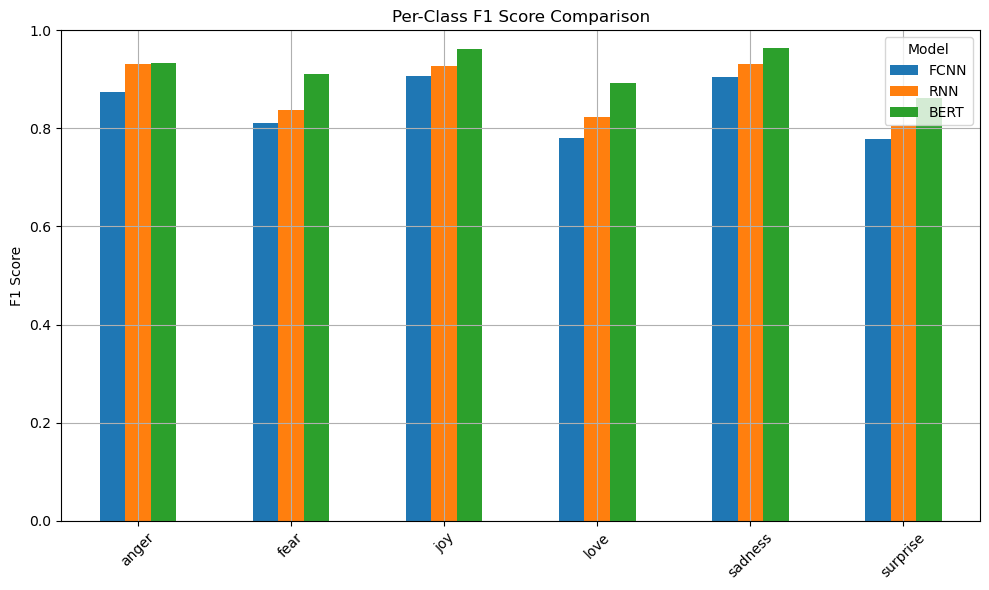

In [36]:
# Get class-wise F1-scores from reports
from sklearn.metrics import classification_report

report_fcnn = classification_report(y_true, y_pred_fcnn, output_dict=True, zero_division=0)
report_rnn = classification_report(y_true, y_pred_rnn, output_dict=True, zero_division=0)
report_bert = classification_report(y_true, y_pred_bert, output_dict=True, zero_division=0)

# Map id2label for pretty printing
id2label = {v: k for k, v in label2id.items()}

f1_df = pd.DataFrame({
    "FCNN": {id2label[int(k)]: v["f1-score"] for k, v in report_fcnn.items() if k.isdigit()},
    "RNN":  {id2label[int(k)]: v["f1-score"] for k, v in report_rnn.items() if k.isdigit()},
    "BERT": {id2label[int(k)]: v["f1-score"] for k, v in report_bert.items() if k.isdigit()},
})

f1_df.plot(kind='bar', figsize=(10, 6))
plt.title("Per-Class F1 Score Comparison")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


BERT consistently outperforms FCNN and RNN across all emotion classes, especially in: joy, sadness, and love, surprise, fear

RNN is a strong middle performer, showing reliable results with modest gaps from BERT.

FCNN generally lags behind, with the lowest F1 scores, especially in fear and surprise, suggesting difficulty capturing subtler or less frequent emotions

BERT shows superior per-class performance, making it the most well-rounded model. This visualization confirms its robustness not only in overall metrics but also in capturing emotional expressions across all categories.

# Conclusion

Our evaluation of three models - FCNN, RNN with LSTM, and BER for emotion classification decisively points to BERT as the best performer.

`BERT` is the best model overall - highly accurate, confident, and consistent across all emotion classes.

`RNN` is a solid alternative, offering decent performance and interpretable insights at a lower computational cost.

`FCNN` serves well as a quick baseline, but doesn’t capture deeper linguistic subtleties.

**BERT** consistently outperformed both FCNN and RNN across all quantitative metrics, including accuracy, precision, recall, and F1-score. This demonstrates its exceptional ability to accurately classify emotions. Beyond overall performance, BERT also achieved the highest F1-scores for individual emotion categories, even for more subtle emotions, showcasing its robust understanding. Its predictions were also the most confident and well-calibrated, indicating high reliability.

In essence, BERT's advanced architecture allows it to capture rich contextual information and nuanced emotional cues, making it the most reliable and effective solution. For real-world applications demanding precise and consistent emotion detection, BERT is clearly the optimal choice.

# How I Would Proceed with Another Text Classification Task


### 1. Understand the Problem

Start by defining the objective clearly:

- What is the classification target? (topic, sentiment, intent)
- How many classes are involved?
- Are the classes balanced?
- Is the text domain-specific? (medical, legal, financial, etc.)


### 2. Data Exploration & Preprocessing

- Clean and normalize the text:
  - Lowercasing
  - Removing special characters, stopwords, punctuation
  - Handling contractions and spelling corrections if needed
- Visualize class distribution:
  - Check for class imbalance using bar plots or pie charts
- Tokenize and prepare the data:
  - Use libraries like `nltk`, `spaCy`, or `transformers`
  - Ensure consistent input lengths (padding/truncation)

### 3. Build Baseline Models

Start with simple models to establish a benchmark:

- **TF-IDF + Logistic Regression/FCNN**: Good for quick evaluation
- **RNN/LSTM**: For sequence-based problems where word order matters
- **Pretrained Transformers (e.g., BERT)**: For deeper contextual understanding



### 4. Evaluate Thoroughly

Use both quantitative and qualitative metrics:

- **Metrics**:
  - Accuracy
  - Precision, Recall, F1-score (macro and per-class)
- **Visualization**:
  - Confusion matrix
  - Classification reports
- **Analysis**:
  - Review sample misclassifications
  - Check confidence scores to understand model calibration



### 5. Select & Fine-Tune the Best Model

- Apply hyperparameter tuning
- Use early stopping to avoid overfitting
- Fine-tune pretrained models (like BERT, RoBERTa, etc.)
- Select the model that balances:
  - Performance
  - Interpretability
  - Inference speed



### 6. Prepare for Deployment

- Save the trained model and tokenizer
- Optimize model for inference




### 7. Next Steps & Iteration

- Improve model performance by:
  - Adding more data
  - Using data augmentation techniques
  - Improving annotations
- Consider using domain-specific language models:
  - e.g., BioBERT, FinBERT
